# Least squares GANs

Christopher Beckham, Montreal Institute for Learning Algorithms

To run code without setup: https://colab.research.google.com/drive/1KN0E_sORG-Bi7evOVtl6jONphI05ZiVL
(Original code derived from: https://github.com/eriklindernoren/Keras-GAN/blob/master/lsgan/lsgan.py)

## Introduction

**This material will not be presented at the workshop and serves as supplementary material to my presentation on GANs. It is probably going to be quite daunting to see all this Keras code if you're new to the framework, so I'm going to try and illustrate what is going on with diagrams and simple equations so that even if you're not completely comfortable with the code you'll have a fairly high-level description of how one trains a GAN in this framework.**

Here we will be using Keras** to write a Least Squares GAN (LSGAN). There are many different types of GANs (each one optimising a different kind of divergence meaure) but the one we'll be using in particular is relatively stable for our purposes, and in particular, this minimises (from the point of view of the discriminator) an approximation of the Chi-squared divergence between the real and generated data distributions (see the original paper [here](https://arxiv.org/abs/1611.04076)).

In [3]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Here is a pretty good illustration summarising the entire GAN (both the generator and the discriminator):

![img](https://deeplearning4j.org/img/GANs.png =600x250)

(Credit: deeplearning4j.org)

Let us define our generator network. The generator is a function $G(\mathbf{z})$ which takes a source of noise sampled from the prior distribution ($\mathbf{z} \sim p(\mathbf{z})$) and returns a sample $\tilde{\mathbf{x}}$. Essentially, the network is an MLP (i.e. multi-layer perceptron, a fully-connected neural network) which takes the $\mathbf{z}$ vector and maps it through a few fully-connected (`Dense`) layers, before reshaping the final output into a 28x28 image.

**Note: for technical reasons (such as speed) I've decided to go with an MLP as the generator, but generally for images you'd want to go with a deconvolutional network, which is obviously designed for images as inputs. In fact, this is what the generator in the above diagram is depicting.**

### Building the generator

The architecture of the generator is the following (in textual form): 

`(z_dim) -> 256 -> 512 -> 1024 -> (28*28)`

`z_dim` is the number of dimensions of our prior distribution $p(\mathbf{z})$. For our case something like 100 is sufficient.

In [0]:
img_shape = (28,28,1)

def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()
    noise = Input(shape=(z_dim,))
    img = model(noise)
    
    return Model(noise, img)


### Building the discriminator

Here we create a discriminator model that takes an image as input and outputs a single value, representing whether the input is real or generated. Unlike normal GANs, the output is not in the range [0,1] and does not represent a probability! Instead, the output should be as close to 1 as possible for real inputs and as close to zero for fake inputs. In this manner, we can think of the discriminator as a margin classifier rather than a probabilistic one (it tries to put all samples from one class on one side of the decision boundary, and samples from the other class on the other side).

The architecture of the discriminator is the following (in textual form):

`(28*28) -> 512 -> 256 -> 1`


In [0]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    # (!!!) No softmax
    model.add(Dense(1))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


Let us load the MNIST digits dataset. We will also select a random sample of images to look at for visualisation purposes.

In [0]:
batch_size = 32

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# Adversarial ground truths
real_label = np.ones((batch_size, 1))
fake_label = np.zeros((batch_size, 1))


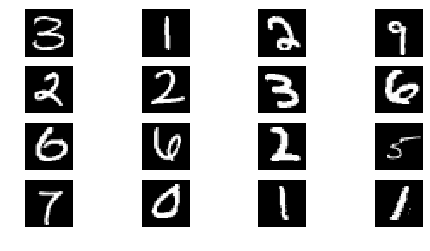

In [9]:
idxs = np.arange(0, len(X_train))
np.random.shuffle(idxs)
c = 0
plt.figure(figsize=(8,4))
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,c+1)
    plt.imshow(X_train[idxs[c],:,:,0], cmap="gray")
    plt.axis('off')
    c += 1

### Understanding the loss function

The LSGAN loss function is very simple to calculate. In a standard GAN, the discriminator has a sigmoid output, representing the probability that samples are real or generated. In  LSGANs, however, the output is linear with no activation function! Instead of being constrained to $[0, 1]$, the discriminator wants to make the classification for real samples be = 1 and fake samples = 0.

To formalise this a little, the discriminator of the GAN is trying to *minimise* this loss:

$ \frac{1}{n}\sum_{i=1}^{n} (D(\mathbf{x}_{i})-1)^{2} + \frac{1}{n}\sum_{i=1}^{n} (D(G(\mathbf{z}_{i}))-0)^{2} $.

Since the generator is trying to fool the discriminator into thinking its samples are actually *real*, it optimises the opposite of the term on the right-hand side, i.e.:

$ \frac{1}{n}\sum_{i=1}^{n} (D(G(\mathbf{z}_{i}))-0)^{2} $

Since the mean-squared error is built into Keras (like it is in most frameworks), it is sufficient to just specify `mse` in the `compile()` method, as you will see below.

In [29]:
# Specify the optimiser. Adam is a pretty
# safe choice these days.
optimizer = Adam(0.0002, 0.5)
# Build and compile the discriminator
discriminator = build_discriminator()
# Print a textual description of the network.
discriminator.summary()
# Compile.
discriminator.compile(loss='mse',
    optimizer=optimizer,
    metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

In [30]:
# Build the generator
z_dim = 100
generator = build_generator(z_dim)

generator.summary()

# The generator takes noise as input and generated imgs
z = Input(shape=(z_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
disc_out = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model(z, disc_out)
# (!!!) Optimize w.r.t. MSE loss instead of crossentropy
combined.compile(loss='mse', 
                 optimizer=optimizer)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              525312    
__________

Have this run for at least 10 minutes. It will take a while but probably not too long!

In [34]:
# The number of iterations.
iters = 20000

for iter_ in range(iters):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real_label)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_label)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(noise, real_label)

    # Plot the progress
    if iter_ % 300 == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter_, d_loss[0], 100*d_loss[1], g_loss))


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.568935, acc.: 57.81%] [G loss: 0.334262]
300 [D loss: 0.062467, acc.: 96.88%] [G loss: 0.808716]
600 [D loss: 0.148674, acc.: 71.88%] [G loss: 0.735381]
900 [D loss: 0.068289, acc.: 90.62%] [G loss: 0.924165]
1200 [D loss: 0.079488, acc.: 95.31%] [G loss: 1.044658]
1500 [D loss: 0.066385, acc.: 93.75%] [G loss: 1.191257]
1800 [D loss: 0.108168, acc.: 87.50%] [G loss: 0.998321]
2100 [D loss: 0.157928, acc.: 79.69%] [G loss: 0.798233]
2400 [D loss: 0.252065, acc.: 56.25%] [G loss: 0.681431]
2700 [D loss: 0.237256, acc.: 62.50%] [G loss: 0.678122]
3000 [D loss: 0.185825, acc.: 71.88%] [G loss: 0.661538]
3300 [D loss: 0.237963, acc.: 57.81%] [G loss: 0.707764]
3600 [D loss: 0.179403, acc.: 71.88%] [G loss: 0.662673]
3900 [D loss: 0.195811, acc.: 71.88%] [G loss: 0.617959]
4200 [D loss: 0.133711, acc.: 84.38%] [G loss: 0.666642]
4500 [D loss: 0.223331, acc.: 62.50%] [G loss: 0.659649]
4800 [D loss: 0.176986, acc.: 76.56%] [G loss: 0.658744]
5100 [D loss: 0.208617, acc.: 68.75%]

### History lesson while you wait for this to train long enough

In practice, training GANs can be quite difficult. For example, one has to carefully balance the model capacity of the discriminator and generator -- if the discriminator is too powerful (relative to the generator) then the generator is unable to learn, and if the discriminator is too weak then nothing useful is going to happen during training. You can determine this 'roughly' by looking at `D loss` and `G loss` during training: if the discriminator loss is significantly lower than the generator loss (e.g. suppose the D loss is 0.01 and the G loss is 0.99) then you may have a problem. To determine whether there is a problem, it is useful to look at the samples from the generator over time to see if they are improving or not. I realise all of this sounds like a bit of 'alchemy' but once you get the hang of it you will really enjoy at what you can accomplish with GANs.

While you can find a plethora of 'tricks' online which help stabilise GAN training, perhaps the most useful one to know about is the 'gradient penalty'. The 'Wasserstein GAN' (WGAN) is also another GAN variant whose discriminator loss has been shown to be nicely correlated with sample quality -- that is, as long as you see it decreasing during training, you can be confident your samples are improving! I talk about this a bit more at the end of this notebook.

## Generating samples

Here we generate a bunch of $\mathbf{z}$'s, feed them to the generator, and plot the outputs.

In [0]:
def sample_images():
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1


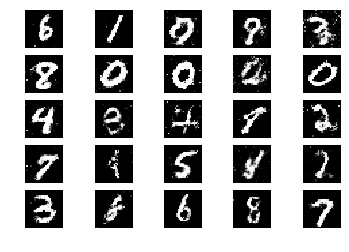

In [36]:
sample_images()

We can interpolate between two $\mathbf{z}$ values and have their intermediate outputs be semantically meaningful.

In [0]:
z1 = np.random.normal(0, 1, size=(1, 100))
z2 = np.random.normal(0, 1, size=(1, 100))


(-0.5, 27.5, 27.5, -0.5)

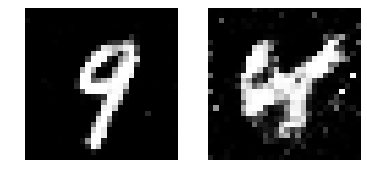

In [41]:
plt.subplot(1,2,1)
gz1 = generator.predict(z1)[0]
gz2 = generator.predict(z2)[0]
plt.imshow(gz1[:,:,0]*0.5 + 0.5, cmap="gray")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gz2[:,:,0]*0.5 + 0.5, cmap="gray")
plt.axis('off')

Let's interpolate along a line! We can plot $g(a \cdot \mathbf{z}_{1} + (1 - a) \cdot \mathbf{z}_{2})$ where $a$ is gradually increased from 0 to 1.

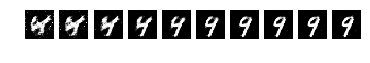

In [42]:
lin = np.linspace(0,1, num=10)
for i in range(10):
  plt.subplot(1,10,i+1)
  gz_mix = generator.predict(z1*lin[i] + z2*(1-lin[i]))[0]
  plt.imshow(gz_mix[:,:,0]*0.5 + 0.5, cmap="gray")
  plt.axis('off')
  

### Where to go from here:

GANs can sometimes be tricky to train in general, but fortunately the recent literature has proposed techniques to make it much easier and less of a hair-ripping experience. Perhaps one of the most important things to know about training GANs is the [gradient penalty](https://arxiv.org/pdf/1704.00028.pdf), which *really* helps to stabilise GAN training. It is basically a regularisation term that you add at the end of your loss function which limits the complexity of the discriminator and therefore its ability to overfit (amongst other things). 

I also mentioned Wasserstein GAN earlier in the notebook. This is a really nice formulation as the author has shown that the learning dynamics of this are a lot more stable and reliable than other GANs. The paper also has empirical evidence to show that the discriminator loss is *well correlated with sample quality*; that is, as long as the discriminator loss is decreasing over time, you can be sure that the samples you get are probably looking good (assuming your discriminator is powerful enough.)